<a href="https://colab.research.google.com/github/anandpuntambekar/Binary_Image_Classiff_cats_dogs/blob/master/Hangman_attempt_5_recap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import re
import collections
#torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [1]:
#1 - not working
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import re
import collections
#torch.autograd.set_detect_anomaly(True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import torch.nn as nn
import torch.nn.init as init

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()

        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 64)  # Increased neurons to 64
        # Second hidden layer
        self.fc2 = nn.Linear(64, 64)  # Introduced an additional layer with 64 neurons
        # Third hidden layer
        self.fc3 = nn.Linear(64, 48)  # Introduced another layer with 48 neurons
        # Output layer
        self.fc4 = nn.Linear(48, output_dim)

        # Initialize weights with Kaiming Initialization for LeakyReLU
        '''
        init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc3.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc4.weight, nonlinearity='leaky_relu')
        '''
        # Define LeakyReLU activation function
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)


class HangmanDQL:
    def __init__(self, word_list):
        self.word_list = word_list
        self.epsilon = 0.2
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 3*0.0001 #0.00055 #0.001
        self.model = QNetwork(26 + 29+5, 26).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.MAX_CHANCES = 10

    def get_state(self, word, used_letters,incorrect_guesses):
        state = [1 if char in used_letters else 0 for char in 'abcdefghijklmnopqrstuvwxyz']
        #word_encoding = [1 if char == "_" else 0 for char in word]

        #word_encoding = [1 if char == "_" else 0 for char in word] + [0] * (29 - len(word))

        # Change word encoding to put -1 if the word is not required or out of scope
        word_encoding = [1 if char == "_" else 0 for char in word] + [-1] * (29 - len(word))

        # a. Length of the word being guessed
        word_length = len(word)

        # b. Count of correct letters guessed in the current word state
        correct_letter_count = sum(word.count(letter) for letter in set(word) if letter != '_')

        # c. Total positions correctly guessed
        correct_positions = len(word) - word_encoding.count(1)

        # d. Total guesses pending
        guesses_pending = len(word) - correct_positions

        # e. Total chances pending
        chances_pending = self.MAX_CHANCES - incorrect_guesses

        state_representation = state + word_encoding
        #print("State representation length:", len(state_representation))

        # sugession
        # If you have gussed first word correctly - add a single state to represent what was the first word
        # If you have gussed last word correctly - add a single state to represent what was the last word
        state_representation = state + word_encoding + [word_length, correct_letter_count, correct_positions, guesses_pending, chances_pending]

        return torch.tensor(state_representation, dtype=torch.float32).unsqueeze(0).to(device)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = self.model(state)
        return chr(torch.argmax(q_values).item() + 97)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
          target = reward
          if not done:
              target = reward + self.gamma * torch.argmax(self.model(next_state)).item()
          '''
          target_q_values = self.model(state)

          # Prepare data for CrossEntropy loss
          action_idx = ord(action) - 97
          loss = self.criterion(target_q_values, torch.tensor([action_idx]).to(device))
          '''
          predicted_q_values = self.model(state)
          target_q_values = predicted_q_values.clone().detach()
          action_idx = ord(action) - 97
          target_q_values[0][action_idx] = target
          loss = nn.MSELoss()(predicted_q_values, target_q_values)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")

        # find length of passed word
        len_word = len(clean_word)

        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.word_list
        new_dictionary = []

        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue

            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)

        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary


        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)

        c = collections.Counter(full_dict_string)
        sorted_letter_count = c.most_common()

        guess_letter = '!'

        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                break

        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    break

        return guess_letter

    def choose_action(self, state, use_guess_function=False):
        if use_guess_function:
            # Transform state back to the word representation
            word = ''.join(['_' if char == 1 else char for char in state[0][-34:-5].tolist()])  # adjusted indices based on your state representation
            return self.guess(word)
        else:
            if np.random.rand() <= self.epsilon:
              return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = nn.functional.softmax(self.model(state), dim=-1)  # Apply softmax here
        return chr(torch.argmax(q_values).item() + 97)

    def train(self, epochs=1000, batch_size=32, guess_epochs=2000):

        for _ in range(epochs):
            use_guess_function = _ < guess_epochs
            use_guess_function=False
            print(f'Training Epoch: {_ + 1}/{epochs}')
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses=0
            done = False
            ## If you have gussed the complete word get a + 10 reward
            ## if you have reached the limit of incorrect gusses you get a -10
            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #action = self.choose_action(state)
                action = self.choose_action(state, use_guess_function)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1
                    incorrect_guesses += 1
                # Check if the entire word has been guessed
                if "_" not in guessed_word:
                    reward = 10
                    done = True

                # Check if the limit of incorrect guesses has been reached
                if incorrect_guesses >= self.MAX_CHANCES:
                    reward = -10
                    done = True

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)

                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            success_rate = self.test(games=500)
            #print(f"Success Rate after Epoch {_ + 1}: {success_rate:.2%}")

    def find_learning_rate(self, init_value=1e-8, final_value=10., beta=0.98):
        num = len(self.memory) - 1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in self.memory:
            batch_num += 1
            # Get a mini-batch of training data
            state, action, reward, next_state, done = data
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            # Smooth the average and compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the learning rate
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr

            # Perform the optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return log_lrs, losses

    def plot_lr_finder(self, log_lrs, losses):
        plt.plot(log_lrs, losses)
        plt.xlabel("Log10 Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

    def populate_memory(self, games=500):
        for _ in range(games):
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses = 0  # Initialize it here
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #print("State shape:", state.shape)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)
                #print(state.shape)
                #print(26 + len(max(self.word_list, key=len)))

    def test(self, games=100):
      total_success = 0

      for _ in range(games):
          word = np.random.choice(self.word_list)
          guessed_word = ["_"] * len(word)
          used_letters = []
          incorrect_guesses = 0
          game_over = False

          while not game_over:
              state = self.get_state("".join(guessed_word), used_letters, incorrect_guesses)
              #q_values = self.model(state).detach().cpu().numpy()  # Get Q-values for actions
              q_values = nn.functional.softmax(self.model(state), dim=-1).detach().cpu().numpy()
              # Exclude already used letters
              for used_letter in used_letters:
                  q_values[0][ord(used_letter) - 97] = -np.inf

              action = chr(np.argmax(q_values) + 97)
              used_letters.append(action)

              if action in word:
                  for i, letter in enumerate(word):
                      if letter == action:
                          guessed_word[i] = action
              else:
                incorrect_guesses += 1  # Increment the counter if the guess was incorrect


              game_over = "_" not in guessed_word or len(used_letters) > 10

          # Check if the game was a success
          if "_" not in guessed_word:
              total_success += 1

      print(f"Success rate: {total_success/games:.2%}")
      return total_success

In [3]:
#2 not working
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()

        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 64)  # Increased neurons to 64
        # Second hidden layer
        self.fc2 = nn.Linear(64, 64)  # Introduced an additional layer with 64 neurons
        # Third hidden layer
        self.fc3 = nn.Linear(64, 48)  # Introduced another layer with 48 neurons
        # Output layer
        self.fc4 = nn.Linear(48, output_dim)

        # Initialize weights with Kaiming Initialization for LeakyReLU
        '''
        init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc3.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc4.weight, nonlinearity='leaky_relu')
        '''
        # Define LeakyReLU activation function
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)
class HangmanDQL:
    def __init__(self, word_list):
        self.word_list = word_list
        self.epsilon = 0.2
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 3*0.0001 #0.00055 #0.001
        self.model = QNetwork(26 + 29+5, 26).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.MAX_CHANCES = 10

    def get_state(self, word, used_letters,incorrect_guesses):
        state = [1 if char in used_letters else 0 for char in 'abcdefghijklmnopqrstuvwxyz']
        #word_encoding = [1 if char == "_" else 0 for char in word]

        #word_encoding = [1 if char == "_" else 0 for char in word] + [0] * (29 - len(word))

        # Change word encoding to put -1 if the word is not required or out of scope
        word_encoding = [1 if char == "_" else 0 for char in word] + [-1] * (29 - len(word))

        # a. Length of the word being guessed
        word_length = len(word)

        # b. Count of correct letters guessed in the current word state
        correct_letter_count = sum(word.count(letter) for letter in set(word) if letter != '_')

        # c. Total positions correctly guessed
        correct_positions = len(word) - word_encoding.count(1)

        # d. Total guesses pending
        guesses_pending = len(word) - correct_positions

        # e. Total chances pending
        chances_pending = self.MAX_CHANCES - incorrect_guesses

        state_representation = state + word_encoding
        #print("State representation length:", len(state_representation))

        # sugession
        # If you have gussed first word correctly - add a single state to represent what was the first word
        # If you have gussed last word correctly - add a single state to represent what was the last word
        state_representation = state + word_encoding + [word_length, correct_letter_count, correct_positions, guesses_pending, chances_pending]

        return torch.tensor(state_representation, dtype=torch.float32).unsqueeze(0).to(device)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = self.model(state)
        return chr(torch.argmax(q_values).item() + 97)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
          target = reward
          if not done:
              target = reward + self.gamma * torch.argmax(self.model(next_state)).item()
          '''
          target_q_values = self.model(state)

          # Prepare data for CrossEntropy loss
          action_idx = ord(action) - 97
          loss = self.criterion(target_q_values, torch.tensor([action_idx]).to(device))
          '''
          predicted_q_values = self.model(state)
          target_q_values = predicted_q_values.clone().detach()
          action_idx = ord(action) - 97
          target_q_values[0][action_idx] = target
          loss = nn.MSELoss()(predicted_q_values, target_q_values)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")

        # find length of passed word
        len_word = len(clean_word)

        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.word_list
        new_dictionary = []

        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue

            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)

        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary


        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)

        c = collections.Counter(full_dict_string)
        sorted_letter_count = c.most_common()

        guess_letter = '!'

        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                break

        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    break

        return guess_letter

    def choose_action(self, state, use_guess_function=False):
        if use_guess_function:
            # Transform state back to the word representation
            word = ''.join(['_' if char == 1 else char for char in state[0][-34:-5].tolist()])  # adjusted indices based on your state representation
            return self.guess(word)
        else:
            if np.random.rand() <= self.epsilon:
              return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = nn.functional.softmax(self.model(state), dim=-1)  # Apply softmax here
        return chr(torch.argmax(q_values).item() + 97)

    def train(self, epochs=1000, batch_size=32, guess_epochs=2000):

        for _ in range(epochs):
            use_guess_function = _ < guess_epochs
            use_guess_function=False
            print(f'Training Epoch: {_ + 1}/{epochs}')
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses=0
            done = False
            ## If you have gussed the complete word get a + 10 reward
            ## if you have reached the limit of incorrect gusses you get a -10
            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #action = self.choose_action(state)
                action = self.choose_action(state, use_guess_function)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1
                    incorrect_guesses += 1
                # Check if the entire word has been guessed
                if "_" not in guessed_word:
                    reward = 10
                    done = True

                # Check if the limit of incorrect guesses has been reached
                if incorrect_guesses >= self.MAX_CHANCES:
                    reward = -10
                    done = True

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)

                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            success_rate = self.test(games=500)
            #print(f"Success Rate after Epoch {_ + 1}: {success_rate:.2%}")

    def find_learning_rate(self, init_value=1e-8, final_value=10., beta=0.98):
        num = len(self.memory) - 1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in self.memory:
            batch_num += 1
            # Get a mini-batch of training data
            state, action, reward, next_state, done = data
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            # Smooth the average and compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the learning rate
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr

            # Perform the optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return log_lrs, losses

    def plot_lr_finder(self, log_lrs, losses):
        plt.plot(log_lrs, losses)
        plt.xlabel("Log10 Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

    def populate_memory(self, games=500):
        for _ in range(games):
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses = 0  # Initialize it here
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #print("State shape:", state.shape)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)
                #print(state.shape)
                #print(26 + len(max(self.word_list, key=len)))

    def test(self, games=100):
      total_success = 0

      for _ in range(games):
          word = np.random.choice(self.word_list)
          guessed_word = ["_"] * len(word)
          used_letters = []
          incorrect_guesses = 0
          game_over = False

          while not game_over:
              state = self.get_state("".join(guessed_word), used_letters, incorrect_guesses)
              #q_values = self.model(state).detach().cpu().numpy()  # Get Q-values for actions
              q_values = nn.functional.softmax(self.model(state), dim=-1).detach().cpu().numpy()
              # Exclude already used letters
              for used_letter in used_letters:
                  q_values[0][ord(used_letter) - 97] = -np.inf

              action = chr(np.argmax(q_values) + 97)
              used_letters.append(action)

              if action in word:
                  for i, letter in enumerate(word):
                      if letter == action:
                          guessed_word[i] = action
              else:
                incorrect_guesses += 1  # Increment the counter if the guess was incorrect


              game_over = "_" not in guessed_word or len(used_letters) > 10

          # Check if the game was a success
          if "_" not in guessed_word:
              total_success += 1

      print(f"Success rate: {total_success/games:.2%}")
      return total_success

In [5]:
#3 working not so well
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import torch.nn as nn
import torch.nn.init as init

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()

        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 64)  # Increased neurons to 64
        # Second hidden layer
        self.fc2 = nn.Linear(64, 64)  # Introduced an additional layer with 64 neurons
        # Third hidden layer
        self.fc3 = nn.Linear(64, 48)  # Introduced another layer with 48 neurons
        # Output layer
        self.fc4 = nn.Linear(48, output_dim)

        # Initialize weights with Kaiming Initialization for LeakyReLU
        '''
        init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc3.weight, nonlinearity='leaky_relu')
        init.kaiming_normal_(self.fc4.weight, nonlinearity='leaky_relu')
        '''
        # Define LeakyReLU activation function
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return nn.functional.softmax(self.fc4(x), dim=-1)  # Softmax added here


class HangmanDQL:
    def __init__(self, word_list):
        self.word_list = word_list
        self.epsilon = 0.2
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 3*0.0001 #0.00055 #0.001
        self.model = QNetwork(26 + 29+5, 26).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.MAX_CHANCES = 10

    def get_state(self, word, used_letters,incorrect_guesses):
        state = [1 if char in used_letters else 0 for char in 'abcdefghijklmnopqrstuvwxyz']
        #word_encoding = [1 if char == "_" else 0 for char in word]

        #word_encoding = [1 if char == "_" else 0 for char in word] + [0] * (29 - len(word))

        # Change word encoding to put -1 if the word is not required or out of scope
        word_encoding = [1 if char == "_" else 0 for char in word] + [-1] * (29 - len(word))

        # a. Length of the word being guessed
        word_length = len(word)

        # b. Count of correct letters guessed in the current word state
        correct_letter_count = sum(word.count(letter) for letter in set(word) if letter != '_')

        # c. Total positions correctly guessed
        correct_positions = len(word) - word_encoding.count(1)

        # d. Total guesses pending
        guesses_pending = len(word) - correct_positions

        # e. Total chances pending
        chances_pending = self.MAX_CHANCES - incorrect_guesses

        state_representation = state + word_encoding
        #print("State representation length:", len(state_representation))

        # sugession
        # If you have gussed first word correctly - add a single state to represent what was the first word
        # If you have gussed last word correctly - add a single state to represent what was the last word
        state_representation = state + word_encoding + [word_length, correct_letter_count, correct_positions, guesses_pending, chances_pending]

        return torch.tensor(state_representation, dtype=torch.float32).unsqueeze(0).to(device)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = self.model(state)
        return chr(torch.argmax(q_values).item() + 97)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
          target = reward
          if not done:
              target = reward + self.gamma * torch.argmax(self.model(next_state)).item()
          target_q_values = self.model(state)

          # Prepare data for CrossEntropy loss
          action_idx = ord(action) - 97
          loss = self.criterion(target_q_values, torch.tensor([action_idx]).to(device))

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, epochs=1000, batch_size=32):

        for _ in range(epochs):
            #print('Epoch:',_)
            print(f'Training Epoch: {_ + 1}/{epochs}')
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses=0
            done = False
            ## If you have gussed the complete word get a + 10 reward
            ## if you have reached the limit of incorrect gusses you get a -10
            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1
                    incorrect_guesses += 1
                # Check if the entire word has been guessed
                if "_" not in guessed_word:
                    reward = 10
                    done = True

                # Check if the limit of incorrect guesses has been reached
                if incorrect_guesses >= self.MAX_CHANCES:
                    reward = -10
                    done = True

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)

                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            success_rate = self.test(games=500)
            #print(f"Success Rate after Epoch {_ + 1}: {success_rate:.2%}")

    def find_learning_rate(self, init_value=1e-8, final_value=10., beta=0.98):
        num = len(self.memory) - 1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in self.memory:
            batch_num += 1
            # Get a mini-batch of training data
            state, action, reward, next_state, done = data
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            #target_q_values[0][ord(action) - 97] = target
            #target_q_values = self.model(state).clone()
            target_q_values = self.model(state)
            target_q_values = target_q_values.clone()
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            # Smooth the average and compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the learning rate
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr

            # Perform the optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return log_lrs, losses

    def plot_lr_finder(self, log_lrs, losses):
        plt.plot(log_lrs, losses)
        plt.xlabel("Log10 Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

    def populate_memory(self, games=500):
        for _ in range(games):
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses = 0  # Initialize it here
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #print("State shape:", state.shape)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)
                #print(state.shape)
                #print(26 + len(max(self.word_list, key=len)))

    def test(self, games=100):
      total_success = 0

      for _ in range(games):
          word = np.random.choice(self.word_list)
          guessed_word = ["_"] * len(word)
          used_letters = []
          incorrect_guesses = 0
          game_over = False

          while not game_over:
              state = self.get_state("".join(guessed_word), used_letters, incorrect_guesses)
              q_values = self.model(state).detach().cpu().numpy()  # Get Q-values for actions

              # Exclude already used letters
              for used_letter in used_letters:
                  q_values[0][ord(used_letter) - 97] = -np.inf

              action = chr(np.argmax(q_values) + 97)
              used_letters.append(action)

              if action in word:
                  for i, letter in enumerate(word):
                      if letter == action:
                          guessed_word[i] = action
              else:
                incorrect_guesses += 1  # Increment the counter if the guess was incorrect


              game_over = "_" not in guessed_word or len(used_letters) > 10

          # Check if the game was a success
          if "_" not in guessed_word:
              total_success += 1

      print(f"Success rate: {total_success/games:.2%}")
      return total_success

In [5]:
#def build_dictionary( full_dictionary_location):
text_file = open(dictionary_file_location,"r")
full_dictionary = text_file.read().splitlines()
text_file.close()
full_dictionary

type(full_dictionary)

list

In [7]:
#4 working
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class HangmanDQL:
    def __init__(self, word_list):
        self.word_list = word_list
        self.epsilon = 0.2
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 #0.00055 #0.001
        self.model = QNetwork(26 + 29+5, 26).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.MAX_CHANCES = 10

    def get_state(self, word, used_letters,incorrect_guesses):
        state = [1 if char in used_letters else 0 for char in 'abcdefghijklmnopqrstuvwxyz']
        #word_encoding = [1 if char == "_" else 0 for char in word]
        word_encoding = [1 if char == "_" else 0 for char in word] + [0] * (29 - len(word))
        # a. Length of the word being guessed
        word_length = len(word)

        # b. Count of correct letters guessed in the current word state
        correct_letter_count = sum(word.count(letter) for letter in set(word) if letter != '_')

        # c. Total positions correctly guessed
        correct_positions = len(word) - word_encoding.count(1)

        # d. Total guesses pending
        guesses_pending = len(word) - correct_positions

        # e. Total chances pending
        chances_pending = self.MAX_CHANCES - incorrect_guesses

        state_representation = state + word_encoding
        #print("State representation length:", len(state_representation))

        state_representation = state + word_encoding + [word_length, correct_letter_count, correct_positions, guesses_pending, chances_pending]

        return torch.tensor(state_representation, dtype=torch.float32).unsqueeze(0).to(device)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = self.model(state)
        return chr(torch.argmax(q_values).item() + 97)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size)
        for i in minibatch:
            state, action, reward, next_state, done = self.memory[i]
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, epochs=1000, batch_size=32):

        for _ in range(epochs):
            #print('Epoch:',_)
            print(f'Training Epoch: {_ + 1}/{epochs}')
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses=0
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1
                    incorrect_guesses += 1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)

                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            success_rate = self.test(games=500)
            #print(f"Success Rate after Epoch {_ + 1}: {success_rate:.2%}")

    def find_learning_rate(self, init_value=1e-8, final_value=10., beta=0.98):
        num = len(self.memory) - 1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in self.memory:
            batch_num += 1
            # Get a mini-batch of training data
            state, action, reward, next_state, done = data
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            # Smooth the average and compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the learning rate
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr

            # Perform the optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return log_lrs, losses

    def plot_lr_finder(self, log_lrs, losses):
        plt.plot(log_lrs, losses)
        plt.xlabel("Log10 Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

    def populate_memory(self, games=500):
        for _ in range(games):
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses = 0  # Initialize it here
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #print("State shape:", state.shape)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)
                #print(state.shape)
                #print(26 + len(max(self.word_list, key=len)))

    def test(self, games=100):
      total_success = 0

      for _ in range(games):
          word = np.random.choice(self.word_list)
          guessed_word = ["_"] * len(word)
          used_letters = []
          incorrect_guesses = 0
          game_over = False

          while not game_over:
              state = self.get_state("".join(guessed_word), used_letters, incorrect_guesses)
              q_values = self.model(state).detach().cpu().numpy()  # Get Q-values for actions

              # Exclude already used letters
              for used_letter in used_letters:
                  q_values[0][ord(used_letter) - 97] = -np.inf

              action = chr(np.argmax(q_values) + 97)
              used_letters.append(action)

              if action in word:
                  for i, letter in enumerate(word):
                      if letter == action:
                          guessed_word[i] = action
              else:
                incorrect_guesses += 1  # Increment the counter if the guess was incorrect


              game_over = "_" not in guessed_word or len(used_letters) > 10

          # Check if the game was a success
          if "_" not in guessed_word:
              total_success += 1

      print(f"Success rate: {total_success/games:.2%}")
      return total_success

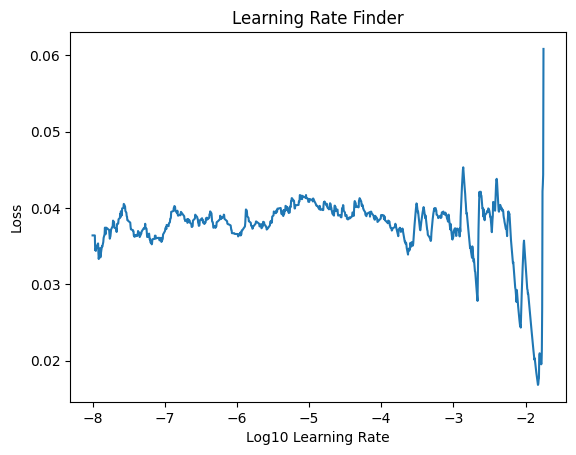

In [8]:

dictionary_file_location ='/content/drive/MyDrive/Anand_Trexquant/words_250000_train.txt'
#def build_dictionary( full_dictionary_location):
text_file = open(dictionary_file_location,"r")
full_dictionary = text_file.read().splitlines()
text_file.close()
full_dictionary

type(full_dictionary)
word_list = ["ability", "absence", "academy", "account", "accuracy", "activity",
             "actually", "addition", "address", "admission", "advantage", "advice",
             "adviser", "affect", "afternoon", "situation", "associate", "attention",
             "attitude", "attribute", "audience", "authority", "available", "awareness",
             "beautiful", "certainly", "challenge", "character", "chocolate", "collection",
             "commercial", "committee", "community", "completely", "complex", "component",
             "conclusion", "condition", "conference", "confidence", "connection", "consciousness",
             "consider", "consistent", "constant", "construction", "contain", "content",
             "contribute", "contribution", "control", "conversation", "cooperation", "corporation",
             "cultural", "currently", "dangerous", "definition", "demonstrate", "department",
             "dependent", "designer", "determine", "developer", "development", "difference",
             "difficulty", "dimension", "direction", "director", "disappear", "discipline",
             "discovery", "discussion", "distribute", "distribution", "diversity", "education",
             "efficiency", "electronic", "employment", "encourage", "engineer", "entertainment",
             "environment", "especially", "establish", "evaluation", "eventually", "everybody",
             "everything", "evidence", "exactly", "examination"]

agent = HangmanDQL(full_dictionary)
agent.populate_memory(games=1000)
log_lrs, losses = agent.find_learning_rate()
agent.plot_lr_finder(log_lrs, losses)



In [ ]:
agent = HangmanDQL(full_dictionary)
agent.train(epochs=5000)
success_count = agent.test(games=100)
print(success_count)